In [79]:
# Find running python kernel
import sys
sys.executable

'C:\\ProgramData\\Anaconda3\\python.exe'

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display
from matplotlib import animation, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Custom Functions

In [2]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:`

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


In [3]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()


## Prior on 1D Data

In [4]:
# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, uncertainty region and samples 
# plot_gp(mu, cov, X, samples=samples)


# Posterior

## Prediction from noise-free training data

Given a training dataset with noise-free function values $\mathbf{f}$ at inputs $\mathbf{X}$, a GP prior can be converted into a GP posterior $p(\mathbf{f}^* \vert \mathbf{X}^*, \mathbf{X}, \mathbf{f})$ which can then be used to make predictions $\mathbf{f}^*$ at new inputs $\mathbf{X}^*$. By definition of a GP, the joint distribution of observed values $\mathbf{f}$ and predictions $\mathbf{f}^*$ is again a Gaussian which can be partitioned into

$$
\begin{pmatrix}
    \mathbf{f} \\
    \mathbf{f}_*
\end{pmatrix} \sim \mathcal{N}
\left(\boldsymbol{0},
\begin{pmatrix}
    \mathbf{K} & \mathbf{K}_* \\
    \mathbf{K}_*^T & \mathbf{K}_{**}
\end{pmatrix}
\right)\tag{2}
$$

$$
\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{f}) &= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*) \\
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{f} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*
\end{align*}
$$

In [5]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s


### 1D Train Data

In [ ]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

In [ ]:
# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
# plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)


## 1D Prediction from noisy training data

In [ ]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)


# Optimization

Optimal values for the kernel parameters $l$ and $\sigma_f$, as well as the noise parameter $\sigma_y$ can be estimated by maximizing the log marginal likelihood which is given by

$$
\log p(\mathbf{y} \lvert \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0}, \mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} 
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix} 
-\frac{N}{2} \log(2\pi)
$$

We will minimize the negative log marginal likelihood w.r.t. parameters $l$ and $\sigma_f$. $\sigma_y$ is set to the known noise level of the data. If the noise level is unknown, σy can be estimated as well along with the other parameters.

In [ ]:
from numpy.linalg import cholesky, det
from scipy.linalg import solve_triangular
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    """
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given
    noise level.

    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (11), if
               False use a numerically more stable implementation.

    Returns:
        Minimization objective.
    """
    
    Y_train = Y_train.ravel()
    
    def nll_naive(theta):
        # Naive implementation of the log marginal likelihood. Works well 
        # for the examples in this article but is numerically less stable 
        # compared to the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)
        
    def nll_stable(theta):
        # Numerically more stable implementation of the log marginal likelihood 
        # as described in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, 
        # Section 2.2, Algorithm 2.1.
        
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        
        S1 = solve_triangular(L, Y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)
        
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.dot(S2) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    if naive:
        return nll_naive
    else:
        return nll_stable

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x

# Compute posterior mean and covariance with optimized kernel parameters and plot the results
mu_s, cov_s = posterior(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
# plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

### 3D Space

In [ ]:
rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

noise_2D = 0.1

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))
Y_2D_train

## Generate Meson data

In [ ]:
q_content = np.random.randint(2, size=(10))
isospin = np.linspace(0, 1.5, 4) 
ang_momentum = np.arange(0, 4.5, 0.5) 
parity = np.array([-1, 1])

# Create new data
def choose(quantity):
    return np.array(np.random.choice(quantity))

X = np.empty([50, 13])

for i in range(50):
    X[i] = np.append(q_content, (choose(isospin), choose(ang_momentum), choose(parity)))


## Using `sklearn`

For Gaussian processes, we need to add an additional value to distinguish between different particles that constitute the same vector, ranked in order of their masses. From the paper, we will also be using the squared exponential (SE) and rational quadratic (RQ) kernels.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic

## Mesons

*Question: How do you handle K-short and K-long?*

In [2]:
import os
os.getcwd()

'E:\\Hasnain\\Uni\\AGenCy Lab\\Codebase\\gp\\freitas-krasserm-turner'

In [10]:
data_file = '../baryons-from-mesons/GaussianProcess/data/mesoninputs.dat'
target_file = '../baryons-from-mesons/GaussianProcess/data/mMass.dat'
test_file = '../baryons-from-mesons/GaussianProcess/data/baryoninputs.dat'
test_target_file = '../baryons-from-mesons/GaussianProcess/data/bMass.dat'

data = np.loadtxt(data_file)
target = np.loadtxt(target_file)
test = np.loadtxt(test_file)
test_target = np.loadtxt(test_target_file)

### Filter out needed test data

In [11]:
# np.where((test == (0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0.5, 1, 0)).all(axis=1))

# 7 baryons: p, n, lambda^{0}, sigma^{+}, sigma^{0}, sigma^{-}, delta^{++}
indices = [0, 1, 2, 5, 6, 7, 24]
X_test = test[indices]
Y_test = test_target[indices]

In [12]:
# Sanity check
np.exp(test_target[indices])

array([ 938.27210729,  939.56781663, 1115.68071016, 1189.37114875,
       1192.64642084, 1197.4505092 , 1231.99489449])

### Initial dataset

In [7]:
# Without the following unknown quark contents:
# f2, a2(1320), π2, η2(1645), a2(1700), η2(1870) 
X = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0],
              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0],
              [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, 0], # η
              [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, 1], # η'
              [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0],
              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0],
              [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, -1, 0],
              [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0.5, 0, -1, 0], #K-short
              [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0.5, 0, -1, 0], #K-long
              [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.5, 1, -1, 0],
              [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0.5, 1, -1, 0],
              [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0.5, 1, -1, 0],
              [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0.5, 1, -1, 0]])

Y = np.array([139.57039, 139.57039, 134.9768, 547.862, 957.78, 775.4, 775.4, 775.49, 782.65, 1019.461,
              493.677, 493.677, 497.611, 497.611, 497.614, 497.614, 891.66, 891.66, 895.55, 895.55])

In [ ]:
# With all particles
# Unknown quark contents set to 0
X = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0],
              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0],
              [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, 0], # η
              [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, 1], # η'
              [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0],
              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0],
              [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, -1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0],     # f2
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0],     # a2(1320)
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, -1, 0],    # π2
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, -1, 0],    # η2(1645)
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1],     # a2(1700) 
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, -1, 1],    # η2(1870)
              [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0.5, 0, -1, 0], # K-short
              [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0.5, 0, -1, 0], # K-long
              [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.5, 1, -1, 0],
              [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0.5, 1, -1, 0],
              [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0.5, 1, -1, 0],
              [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0.5, 1, -1, 0]])

Y = np.array([139.57039, 139.57039, 134.9768, 547.862, 957.78, 775.4, 775.4, 775.49, 782.65, 1019.461,
              1275.5, 1316.9, 1670.6, 1617.0, 1705.0, 1842, # unknown quark contents
              493.677, 493.677, 497.611, 497.611, 497.614, 497.614, 891.66, 891.66, 895.55, 895.55])

In [4]:
# Normalize log masses to have 0 mean and unit variance
scaler = StandardScaler()
Y_log = np.log(Y)

# Not needed if passing `normalize_y=True` when constructing GP object
Y_normalized = scaler.fit_transform(Y_log.reshape(-1, 1)).ravel()

## Kernels

Recall the covariance function

$$\mathrm{cov}(\mathbf{x}_i,\mathbf{x}_j) = \kappa(\mathbf{x}_i,\mathbf{x}_j) + N_{i,j} \;, \text{where} \; N_{i,j} = \sigma_y^2 \delta_{i,j}$$

where the squared exponential can be written as

$$
K_{\textrm{SE}}(\mathbf{x}_i,\mathbf{x}_j) =
\sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)
$$

and the rational quadratic kernel is

$$
K_{\textrm{RQ}}(\mathbf{x}_i,\mathbf{x}_j) =
\sigma_f^2 \exp\left(1 + \frac{1}{2 \alpha}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)^{-\alpha}
$$

The prior's covariance is specified by the kernel function. The prior mean is assumed to be data's mean if `normalize_y=True` is passed, and set to constant and $0$ otherwise. 

Hyperparameters of the kernel are optimized during fitting by maximizing the log-marginal-likelihood, based on the passed optimizer. Optimizer can be started repeatedly by specifying the `n_restarts_optimizer` parameter, as it may have multiple local optima.

Starting from the initial hyperparameter values of the kernel, subsequent runs are conducted from hyperparameter values that have been chosen randomly from the range of allowed values.

The noise level in the targets can be specified by passing it via the parameter `alpha`, either globally as a scalar or per datapoint. This is added to the diagonal of the kernel matrix during fitting. It can also be interpreted as the variance of additional Gaussian measurement noise on the training observations.

The `RBF`/`SE` kernel only has an `l` parameter which corresponds to the `length_scale` parameter. To have a $\sigma_f$ parameter as well, we have to compose the `RBF` kernel with a `ConstantKernel`. `l` can either be a scalar (isotropic variant of the kernel) or a vector with the same number of dimensions as the inputs X (anisotropic variant of the kernel).

The `RationalQuadratic` kernel is parameterized by a length scale parameter $l > 0$ and a scale mixture parameter $\alpha > 0$. Only the isotropic variant where `length_scale` is a scalar is supported by `sklearn`.

In [6]:
# Reshape Y_log or Y_normalized to (-1, 1) if adding noise
Y_log = Y_log.reshape(-1, 1)
Y_normalized = Y_normalized.reshape(-1, 1)

In [7]:
np.mean(Y_log), np.std(Y_log)

(6.296347305073987, 0.6286352637696876)

In [46]:
noise = 1.4**2
rbf = ConstantKernel(0.6) * RBF(length_scale=1.2)
# rq = ConstantKernel(1.0) * RationalQuadratic(length_scale=1.0, alpha=1.0)

# Set GP prior to training data's mean and cov with kernel
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise, n_restarts_optimizer=10)#, normalize_y=True)
# gpr = GaussianProcessRegressor(kernel=rq, alpha=noise**2, normalize_y=True)

# Add noise if needed
# Y_noisy = Y_log + noise * np.random.randn(*X.shape)

### Experiment 2: Meson-Baryon Train-Test

In [47]:
X_train, Y_train = data, target 

print('X_Train: ', X_train.shape, 'X_Test: ', X_test.shape, 'Y_train: ', Y_train.shape, 'Y_test: ', Y_test.shape)
print('Y_test: ', Y_test)

X_Train:  (196, 14) X_Test:  (7, 14) Y_train:  (196,) Y_test:  (7,)
Y_test:  [6.84404 6.84542 7.01722 7.08118 7.08393 7.08795 7.11639]


### Experiment 1: 80-20 Meson Split

In [6]:
# 80-20 train-test split
# Replace the Y's with Y_log, Y_normalized, or Y_noisy as needed
X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2, shuffle=True)

print('X_Train: ', X_train.shape, 'X_Test: ', X_test.shape, 'Y_train: ', Y_train.shape, 'Y_test: ', Y_test.shape)
print('Y_test: ', Y_test)

X_Train:  (156, 14) X_Test:  (40, 14) Y_train:  (156,) Y_test:  (40,)
Y_test:  [7.62315307 7.14834574 7.45007957 7.41878088 7.28961052 9.30500489
 4.93857064 7.42093812 7.76004068 7.24636808 7.62315307 7.41577698
 7.85131092 7.81010935 7.26283896 7.25911613 6.71417053 7.59337419
 6.86461811 7.48211892 6.88755257 9.24524409 9.23556553 7.44132039
 8.33009223 8.27568198 6.79743805 8.39412119 9.26141364 7.06475903
 7.21081845 7.42093812 8.34069465 7.17011954 7.57250299 7.32974969
 7.26710664 7.53350653 7.44132039 8.24858145]


In [48]:
# Sanity check: Convert changing normalized log value back to MeV scale
np.exp(Y_test[0])

# np.exp((-0.13763566 * np.std(Y_log)) + np.mean(Y_log))

938.2721072927486

### Training to find posterior mean and covariance

[ 920.86037554  942.17438496 1037.43167509  815.76497722  845.53453601
  853.61661467  856.43926288] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.5253035  0.56392013 0.48741778 0.54007148 0.47415336 0.54962125
 0.660868  ] 

RMSE:  0.21675824074252784
length scale, sigma_f, noise: 23.028433824314828 8.01674916078521 1.9599999999999997


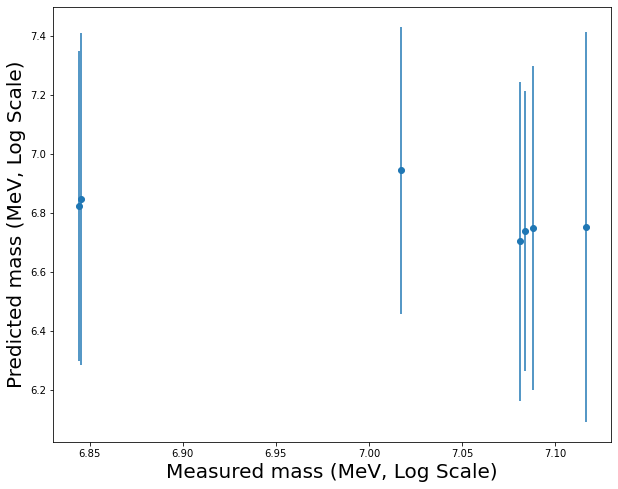

In [49]:
# Declare cache
# results = {'mean': np.zeros((iter, X_test.shape[0])), 'cov': np.zeros((iter, X_test.shape[0])),
#            'length_scales': np.zeros(iter), 'sigma_f': np.zeros(iter)}

# Reuse training data
gpr.fit(X_train, Y_train)

mean, cov = gpr.predict(X_test, return_std=True)

# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

print(np.exp(mean), '\n', np.exp(Y_test), '\n', cov, '\n')
print('RMSE: ', mean_absolute_error(Y_test, mean))
print('length scale, sigma_f, noise:', l, sigma_f, noise)

# Plot
plotter(Y_test, mean, cov)

In [27]:
hyperparams = list(zip(constant_value, length_scale))

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 0.6, length_scale: 0.6
[ 920.860511    942.17453589 1037.43183048  815.7650834   845.53464781
  853.61674849  856.43936233] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.5253034  0.56392001 0.48741767 0.54007137 0.47415326 0.54962114
 0.66086788] 



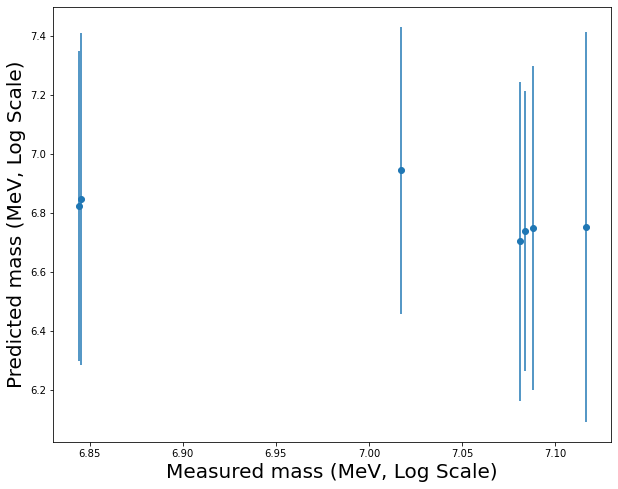

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 0.7, length_scale: 0.7
[ 920.85869219  942.17252713 1037.42992543  815.76359299  845.53322412
  853.61491213  856.43768377] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530461 0.56392135 0.48741895 0.54007263 0.47415446 0.54962237
 0.66086926] 



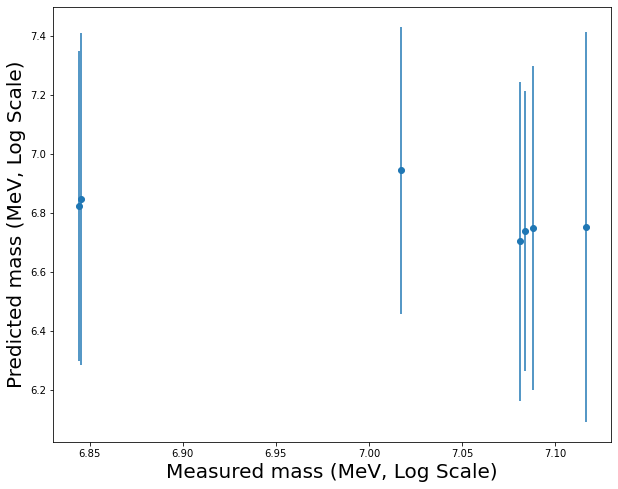

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 0.7999999999999999, length_scale: 0.7999999999999999
[ 920.85993912  942.17392681 1037.4314627   815.76453219  845.53429875
  853.61612051  856.43839664] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530353 0.56392015 0.48741779 0.5400715  0.47415338 0.54962129
 0.66086806] 



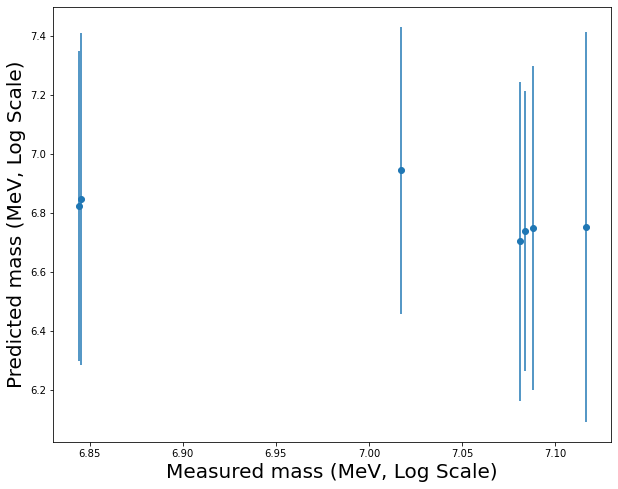

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 0.8999999999999999, length_scale: 0.8999999999999999
[ 920.86034727  942.17435103 1037.43161762  815.76496401  845.53450201
  853.61659223  856.43928957] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530355 0.56392018 0.48741784 0.54007153 0.47415341 0.5496213
 0.66086805] 



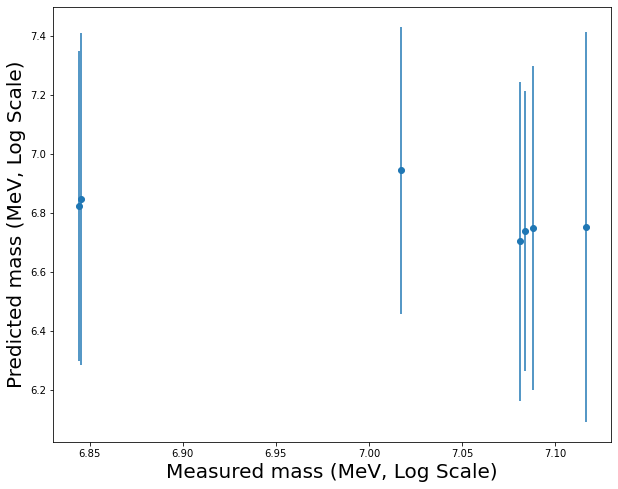

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 0.9999999999999999, length_scale: 0.9999999999999999
[ 920.86040184  942.17441482 1037.431711    815.76499579  845.53456016
  853.61663939  856.43927132] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530347 0.5639201  0.48741775 0.54007145 0.47415334 0.54962122
 0.66086797] 



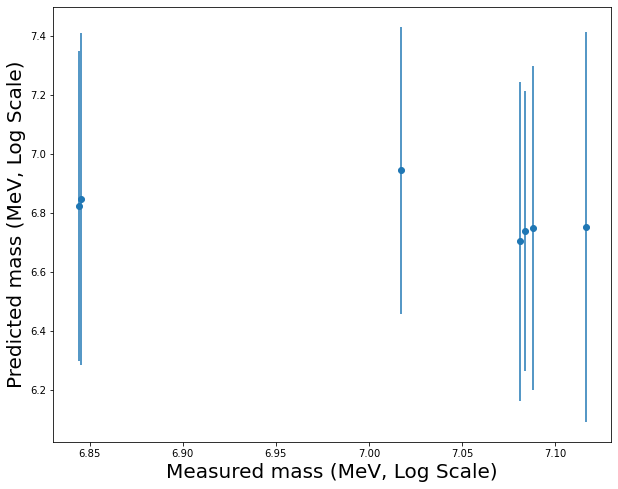

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 1.0999999999999999, length_scale: 1.0999999999999999
[ 920.86041376  942.17442803 1037.43172382  815.76500545  845.53456964
  853.61665137  856.43928172] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530347 0.56392009 0.48741775 0.54007144 0.47415333 0.54962122
 0.66086796] 



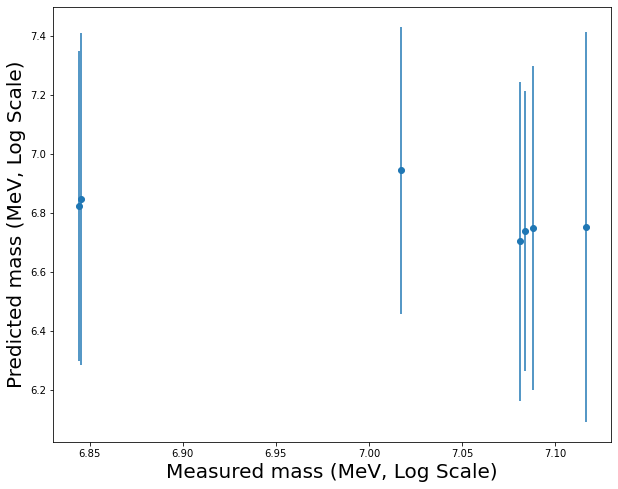

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 1.1999999999999997, length_scale: 1.1999999999999997
[ 920.86033214  942.17433718 1037.4316312   815.7649411   845.53450271
  853.61657051  856.43921988] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530353 0.56392016 0.48741781 0.54007151 0.47415339 0.54962128
 0.66086803] 



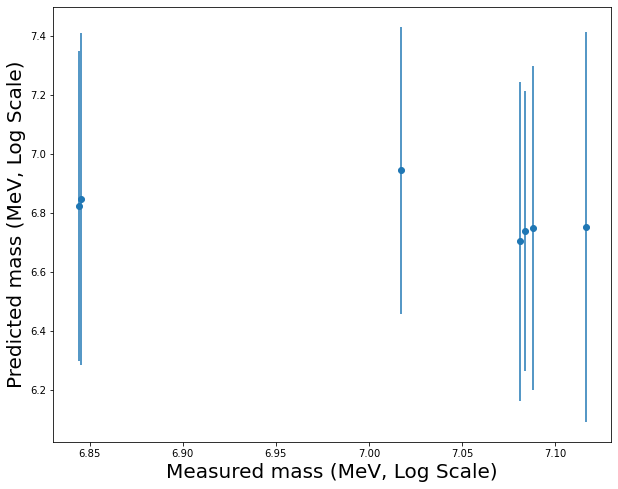

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 1.2999999999999998, length_scale: 1.2999999999999998
[ 920.86067442  942.17471678 1037.43200581  815.76521583  845.53477749
  853.61691257  856.43950527] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530328 0.56391988 0.48741755 0.54007125 0.47415315 0.54962103
 0.66086775] 



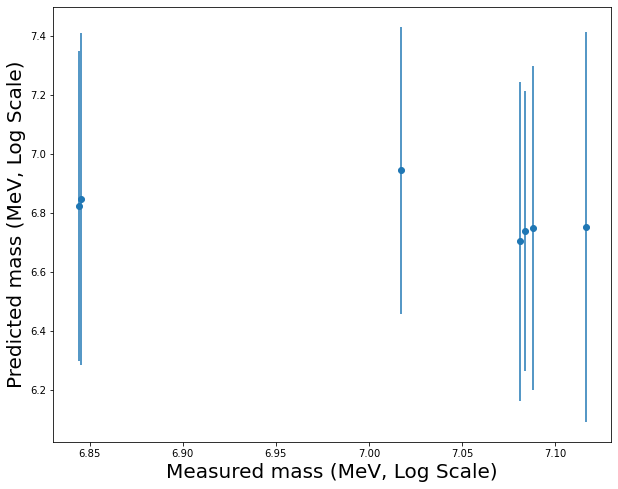

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 1.4, length_scale: 1.4
[ 920.86028604  942.1742854  1037.43157397  815.76490652  845.53446281
  853.61652593  856.43919428] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530357 0.5639202  0.48741785 0.54007155 0.47415343 0.54962132
 0.66086807] 



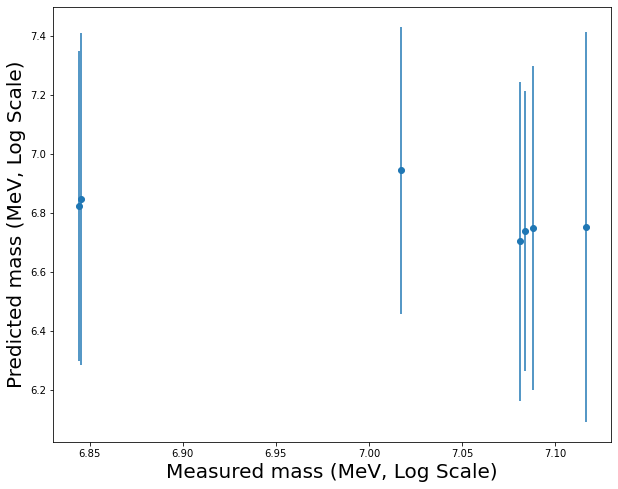

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 1.4999999999999998, length_scale: 1.4999999999999998
[ 920.86041017  942.17442277 1037.4317069   815.76500719  845.53456121
  853.61665061  856.4393033 ] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530348 0.5639201  0.48741776 0.54007146 0.47415335 0.54962123
 0.66086798] 



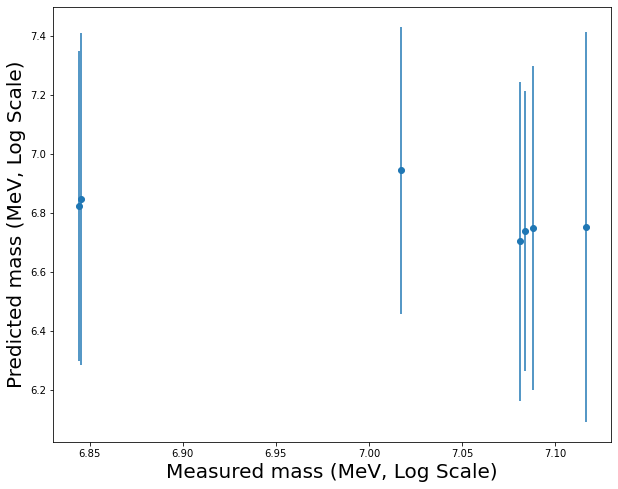

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 1.5999999999999996, length_scale: 1.5999999999999996
[ 920.86069659  942.17473166 1037.4319304   815.76526923  845.53475279
  853.61695654  856.43971254] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530337 0.56391999 0.48741766 0.54007135 0.47415324 0.54962112
 0.66086785] 



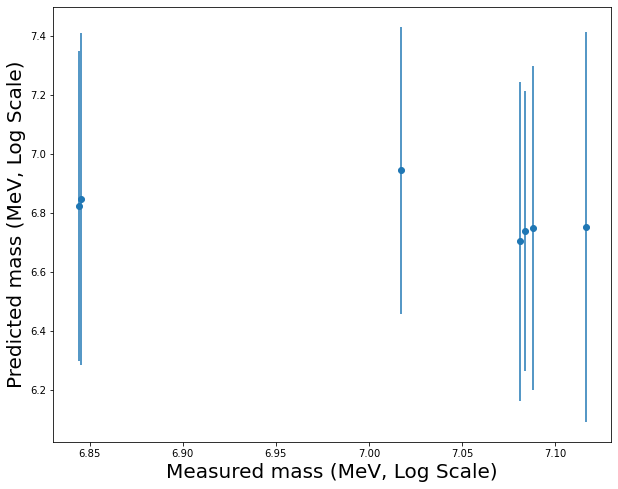

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 1.6999999999999997, length_scale: 1.6999999999999997
[ 920.86039538  942.17440761 1037.43170345  815.76499077  845.53455477
  853.61663304  856.43926684] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530348 0.5639201  0.48741776 0.54007146 0.47415334 0.54962123
 0.66086797] 



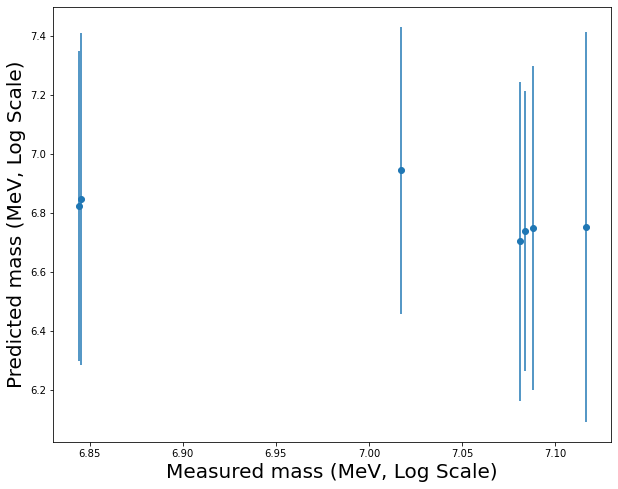

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 1.7999999999999998, length_scale: 1.7999999999999998
[ 920.86030564  942.17430425 1037.43156576  815.76493285  845.5344659
  853.616552    856.43926679] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530359 0.56392022 0.48741788 0.54007157 0.47415345 0.54962134
 0.66086809] 



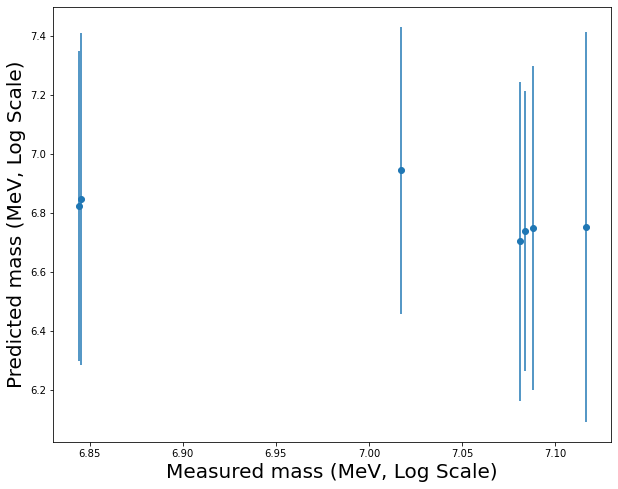

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 1.9, length_scale: 1.9
[ 920.8604387   942.17445635 1037.43175792  815.76502303  845.53459256
  853.6166748   856.43928961] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530344 0.56392006 0.48741772 0.54007142 0.4741533  0.54962119
 0.66086793] 



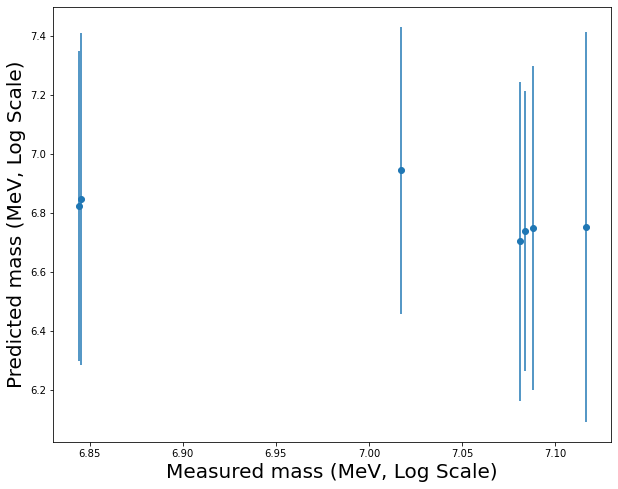

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 1.9999999999999996, length_scale: 1.9999999999999996
[ 920.86058745  942.17462274 1037.43193546  815.76513715  845.53471827
  853.61682022  856.4393857 ] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530332 0.56391992 0.48741759 0.54007129 0.47415318 0.54962107
 0.66086779] 



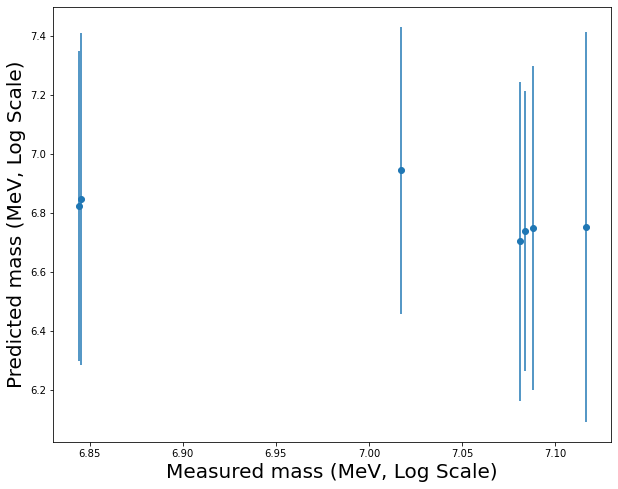

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 2.0999999999999996, length_scale: 2.0999999999999996
[ 920.86035982  942.17436846 1037.43166751  815.76496117  845.53452749
  853.61659686  856.43923156] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.5253035  0.56392013 0.48741778 0.54007148 0.47415336 0.54962125
 0.660868  ] 



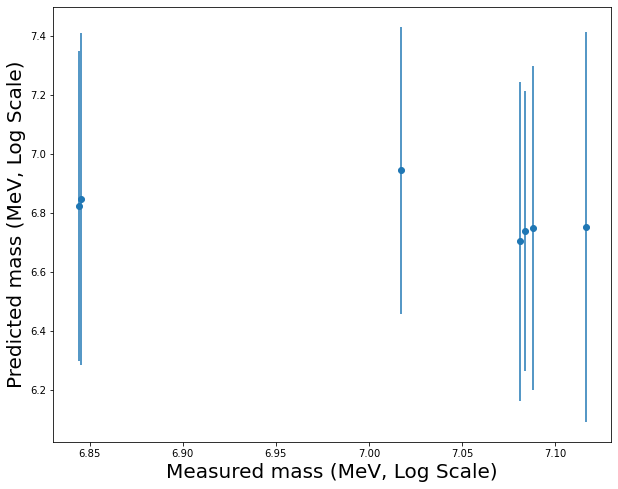

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 2.1999999999999997, length_scale: 2.1999999999999997
[ 920.86070821  942.17476001 1037.43210181  815.76522188  845.53482979
  853.61693344  856.43942169] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530319 0.56391979 0.48741745 0.54007116 0.47415306 0.54962094
 0.66086766] 



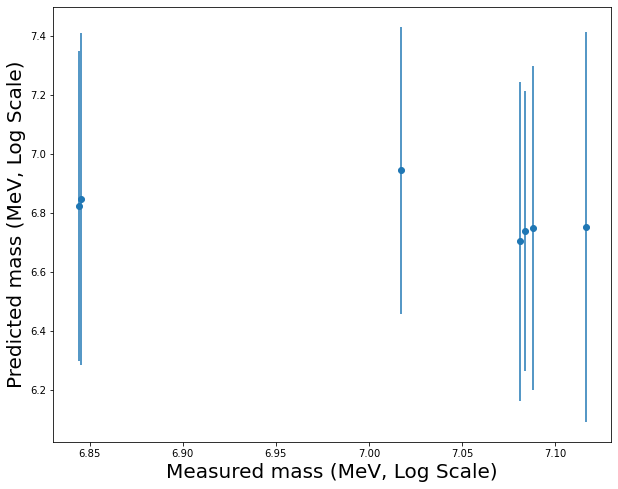

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 2.3, length_scale: 2.3
[ 920.86046414  942.17448104 1037.43174968  815.76505633  845.5345976
  853.61670811  856.43937914] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530346 0.56392008 0.48741774 0.54007144 0.47415333 0.54962121
 0.66086795] 



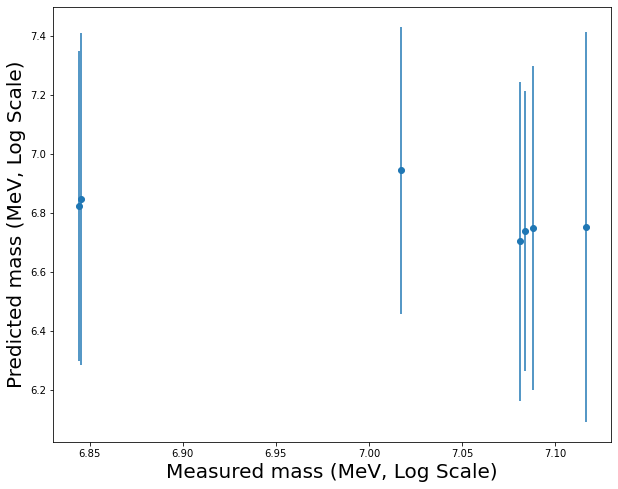

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 2.3999999999999995, length_scale: 2.3999999999999995
[ 920.86037448  942.17438467 1037.43168296  815.76497315  845.53453901
  853.61661164  856.43924492] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530349 0.56392012 0.48741777 0.54007147 0.47415335 0.54962124
 0.66086799] 



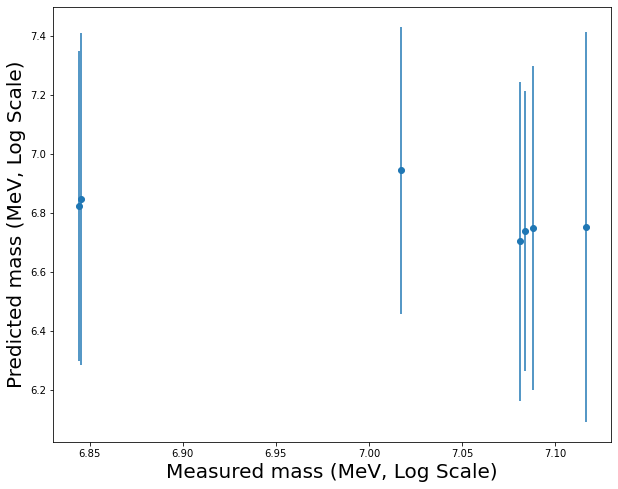

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 2.4999999999999996, length_scale: 2.4999999999999996
[ 920.86045979  942.17447874 1037.43177087  815.76504357  845.53460517
  853.61669809  856.43932637] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530344 0.56392005 0.48741771 0.54007141 0.4741533  0.54962119
 0.66086793] 



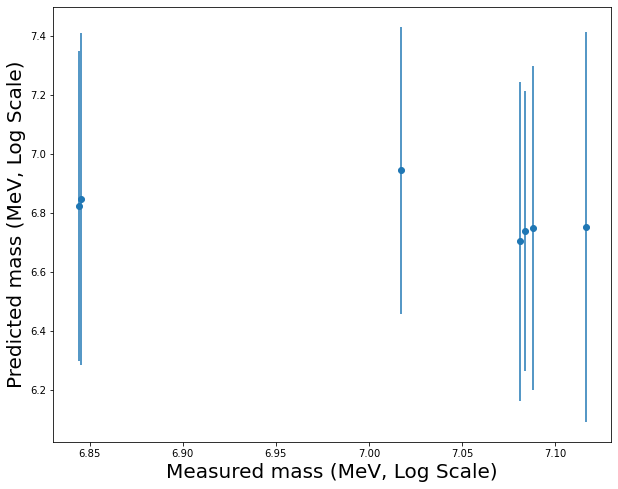

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 2.5999999999999996, length_scale: 2.5999999999999996
[ 920.86040788  942.17442185 1037.43172098  815.76499944  845.53456645
  853.6166447   856.43927   ] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530347 0.56392009 0.48741775 0.54007144 0.47415333 0.54962122
 0.66086796] 



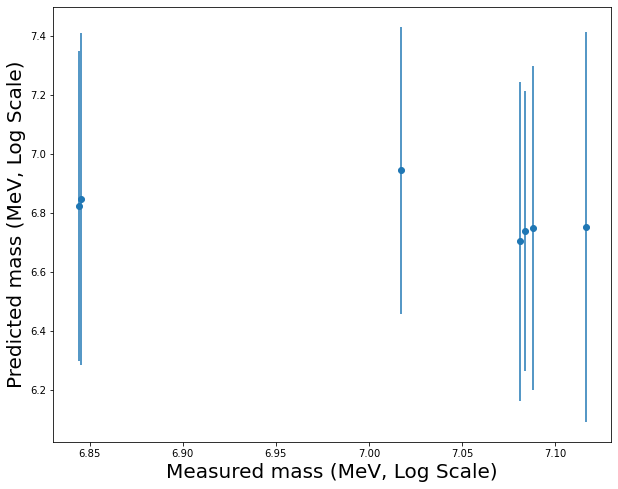

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 2.6999999999999997, length_scale: 2.6999999999999997
[ 920.86044563  942.17446613 1037.43178716  815.76502085  845.53460736
  853.61667698  856.43925435] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530341 0.56392003 0.48741769 0.54007139 0.47415327 0.54962116
 0.6608679 ] 



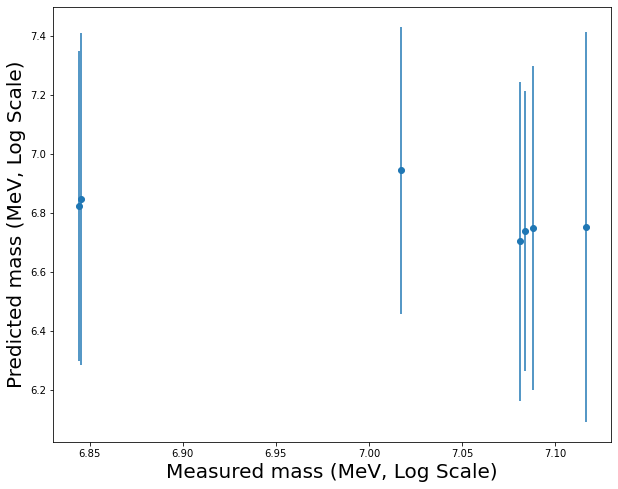

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 2.7999999999999994, length_scale: 2.7999999999999994
[ 920.86041887  942.17443432 1037.43173581  815.76500726  845.53457647
  853.61665507  856.43927384] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530346 0.56392007 0.48741773 0.54007143 0.47415332 0.54962121
 0.66086795] 



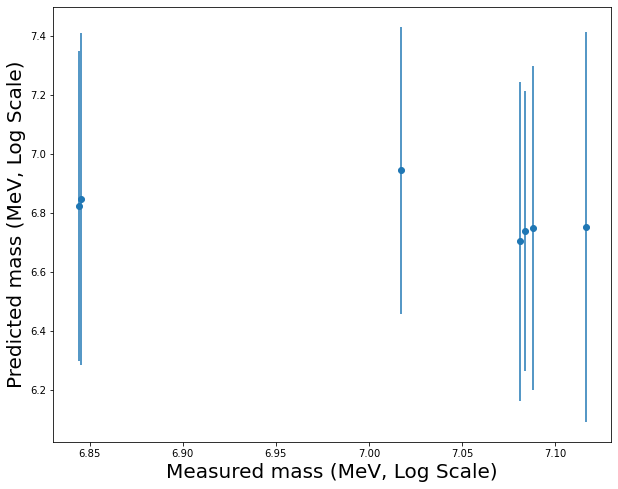

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 2.8999999999999995, length_scale: 2.8999999999999995
[ 920.86048651  942.17451199 1037.43183722  815.76505176  845.53464245
  853.61671667  856.43927837] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530338 0.56391999 0.48741765 0.54007135 0.47415324 0.54962113
 0.66086786] 



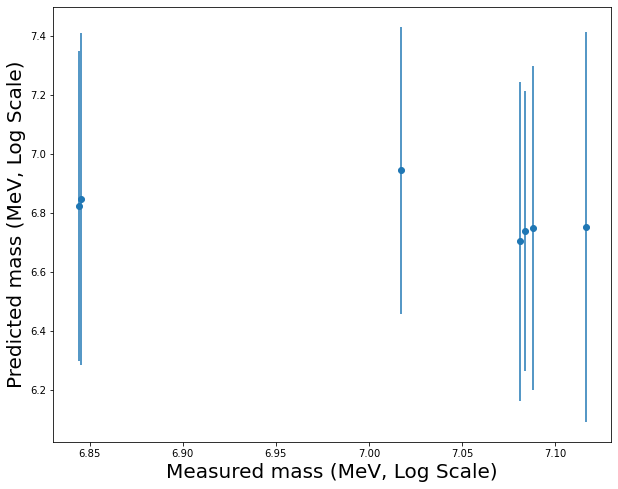

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 2.9999999999999996, length_scale: 2.9999999999999996
[ 920.86039725  942.17440985 1037.43170723  815.76499165  845.53455701
  853.61663453  856.43926511] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530348 0.5639201  0.48741776 0.54007145 0.47415334 0.54962123
 0.66086797] 



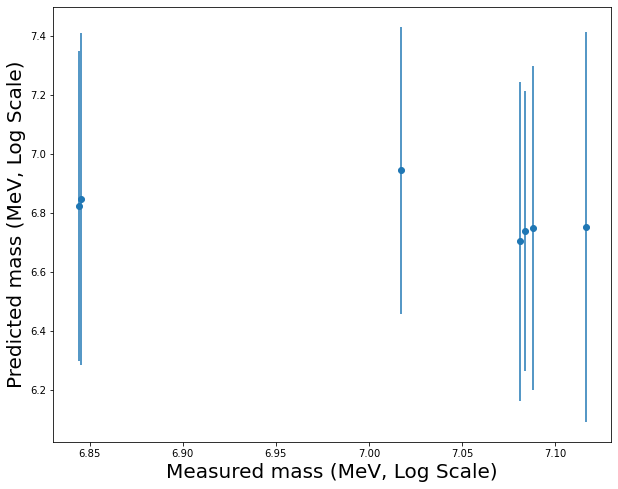

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 3.0999999999999996, length_scale: 3.0999999999999996
[ 920.86038911  942.17440026 1037.43169246  815.76498722  845.53454798
  853.61662769  856.43926944] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530349 0.56392011 0.48741777 0.54007147 0.47415335 0.54962124
 0.66086798] 



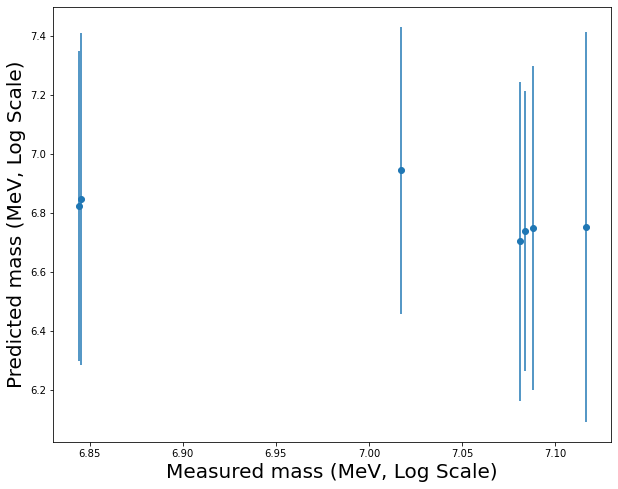

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 3.1999999999999997, length_scale: 3.1999999999999997
[ 920.86034235  942.17435296 1037.43168803  815.764933    845.53453037
  853.61657073  856.43914194] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530347 0.56392009 0.48741775 0.54007145 0.47415333 0.54962122
 0.66086797] 



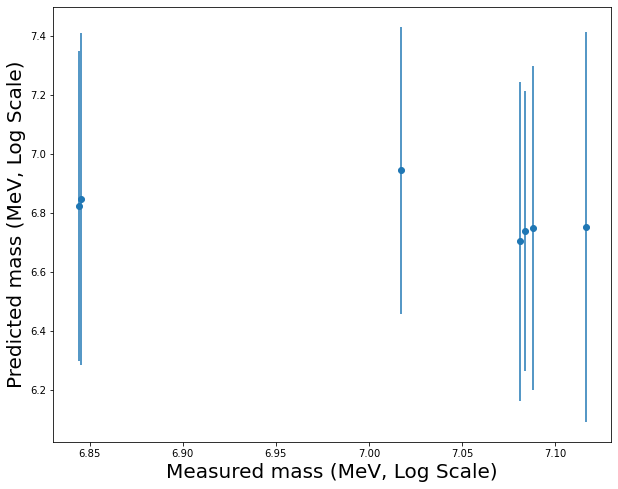

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 3.2999999999999994, length_scale: 3.2999999999999994
[ 920.86037695  942.17438734 1037.43168503  815.76497536  845.53454072
  853.61661424  856.43924817] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530349 0.56392011 0.48741777 0.54007147 0.47415335 0.54962124
 0.66086799] 



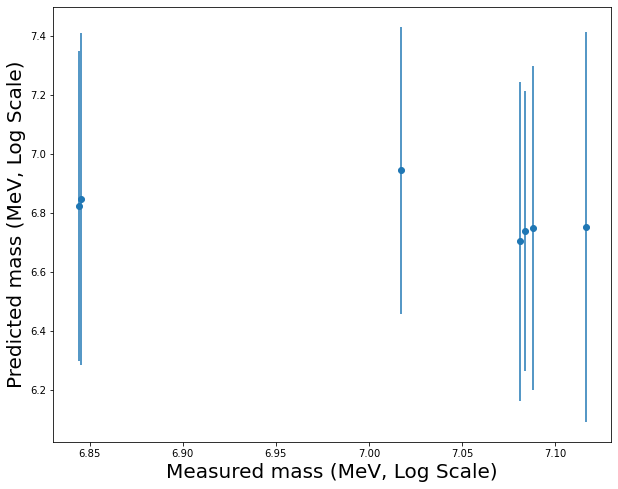

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 3.3999999999999995, length_scale: 3.3999999999999995
[ 920.86027052  942.17426763 1037.43155131  815.76489608  845.53444793
  853.61651165  856.43919206] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530359 0.56392022 0.48741787 0.54007157 0.47415345 0.54962134
 0.66086809] 



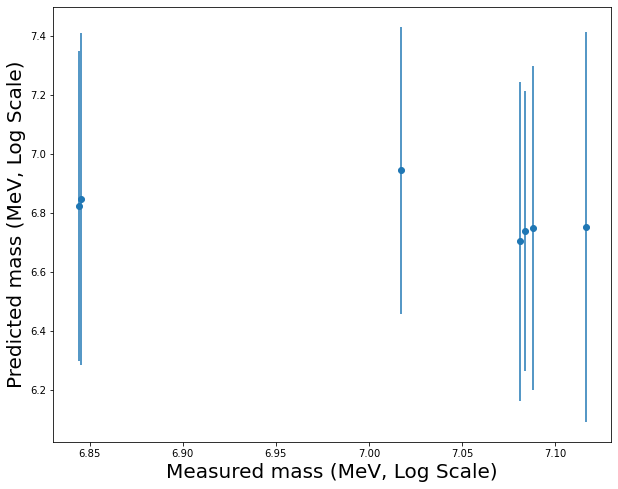

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 3.4999999999999996, length_scale: 3.4999999999999996
[ 920.86041568  942.17443013 1037.43172576  815.76500703  845.53457111
  853.61665331  856.4392836 ] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530346 0.56392009 0.48741774 0.54007144 0.47415333 0.54962121
 0.66086796] 



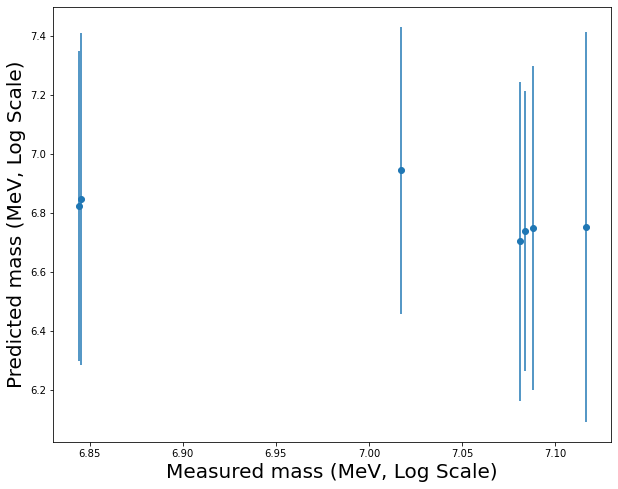

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 3.599999999999999, length_scale: 3.599999999999999
[ 920.86038678  942.17439867 1037.43170014  815.7649817   845.53455047
  853.61662312  856.43924814] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530348 0.5639201  0.48741776 0.54007146 0.47415334 0.54962123
 0.66086797] 



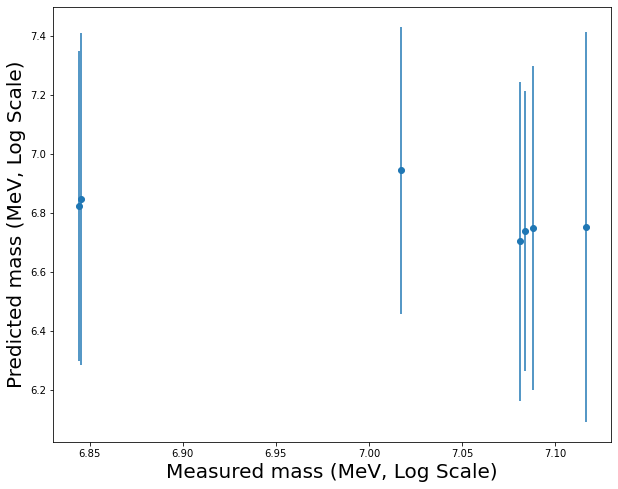

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 3.6999999999999993, length_scale: 3.6999999999999993
[ 920.8603667   942.17437581 1037.43167212  815.76496774  845.53453177
  853.61660438  856.43924284] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.5253035  0.56392012 0.48741778 0.54007148 0.47415336 0.54962125
 0.660868  ] 



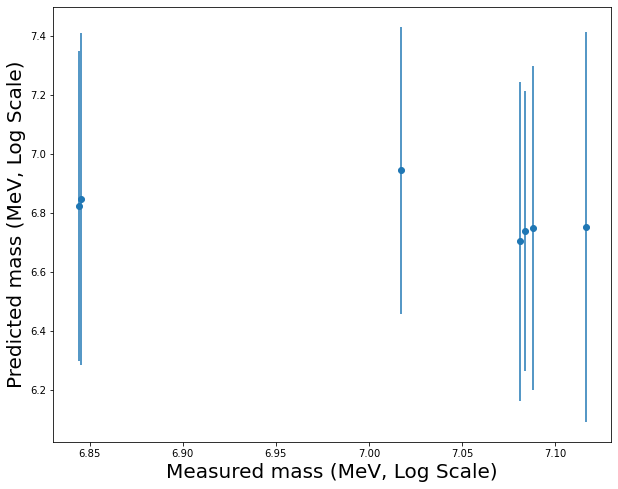

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 3.7999999999999994, length_scale: 3.7999999999999994
[ 920.86291673  942.17722965 1037.43472789  815.76691989  845.53669191
  853.61909481  856.4408674 ] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530139 0.56391778 0.48741552 0.54006928 0.47415125 0.54961912
 0.66086564] 



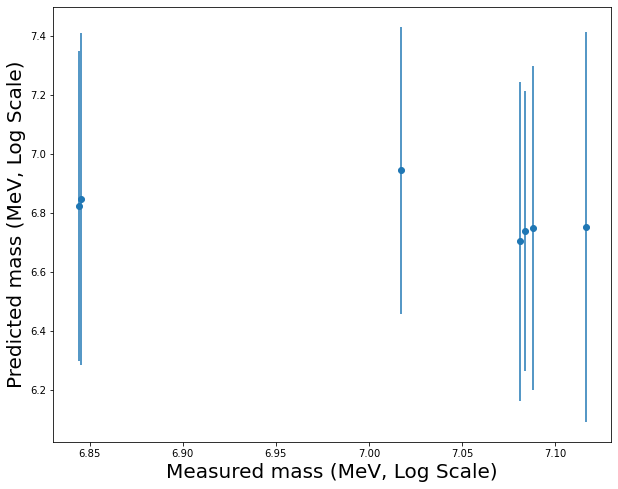

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 3.8999999999999995, length_scale: 3.8999999999999995
[ 920.86044988  942.17446815 1037.43176407  815.76503417  845.53459894
  853.6166873   856.43931045] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530344 0.56392006 0.48741772 0.54007142 0.4741533  0.54962119
 0.66086793] 



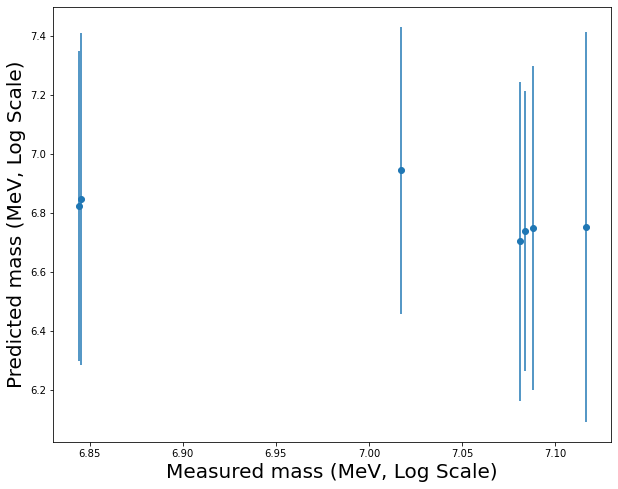

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 3.9999999999999996, length_scale: 3.9999999999999996
[ 920.86039161  942.17440371 1037.43170226  815.7649867   845.534553
  853.61662863  856.43925814] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530348 0.5639201  0.48741776 0.54007146 0.47415334 0.54962123
 0.66086797] 



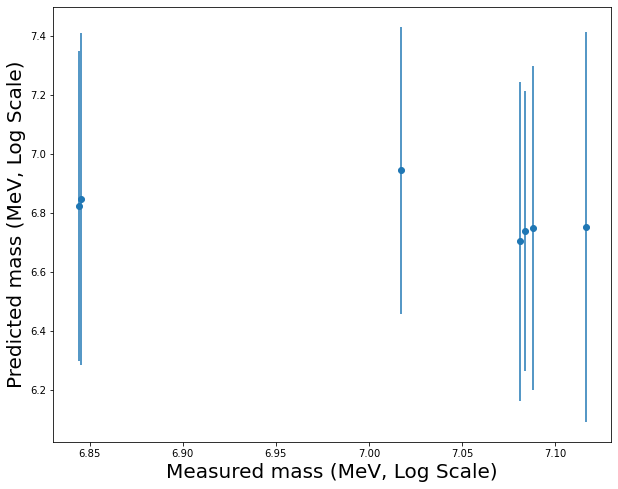

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 4.099999999999999, length_scale: 4.099999999999999
[ 920.86091117  942.17498651 1037.4323386   815.76537953  845.53499898
  853.61713305  856.43956312] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530303 0.56391961 0.48741728 0.54007099 0.4741529  0.54962078
 0.66086748] 



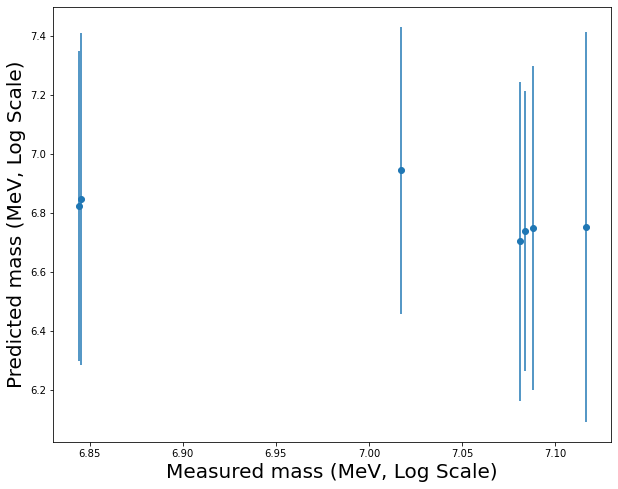

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 4.199999999999999, length_scale: 4.199999999999999
[ 920.86027124  942.17427187 1037.43158737  815.76488407  845.53446355
  853.61650466  856.43912586] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530355 0.56392018 0.48741783 0.54007153 0.47415341 0.5496213
 0.66086805] 



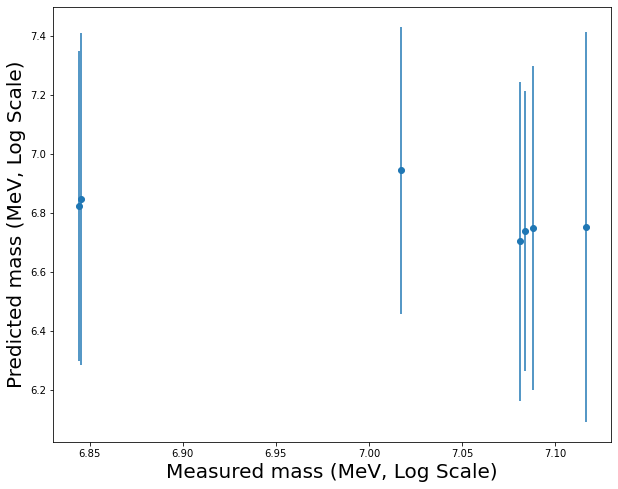

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 4.299999999999999, length_scale: 4.299999999999999
[ 920.86047536  942.17449418 1037.43176906  815.76506281  845.53460964
  853.61671778  856.43937507] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530345 0.56392006 0.48741773 0.54007142 0.47415331 0.54962119
 0.66086793] 



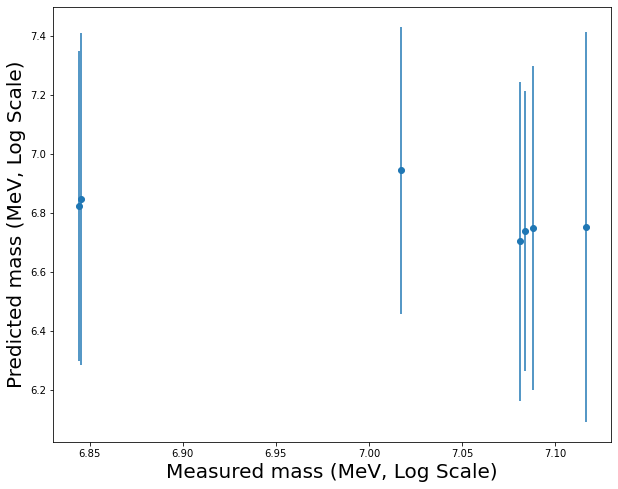

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 4.399999999999999, length_scale: 4.399999999999999
[ 920.86038574  942.17439757 1037.43169964  815.76498063  845.53454991
  853.61662193  856.43924604] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530348 0.5639201  0.48741776 0.54007146 0.47415334 0.54962123
 0.66086798] 



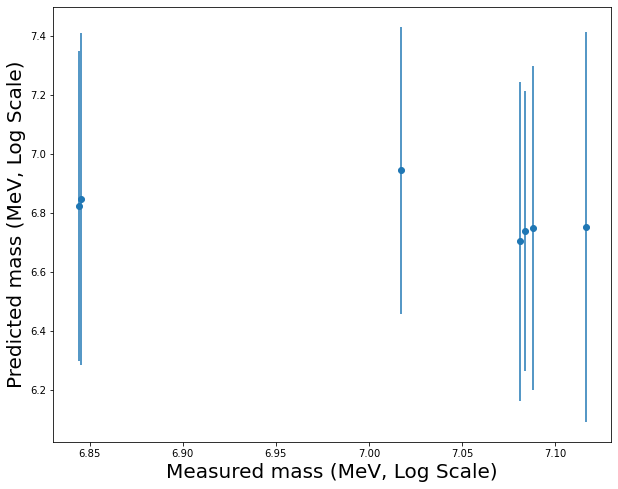

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 4.499999999999999, length_scale: 4.499999999999999
[ 920.86045478  942.17447089 1037.43174178  815.76504799  845.53459108
  853.61669825  856.43936691] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530347 0.56392009 0.48741775 0.54007144 0.47415333 0.54962121
 0.66086796] 



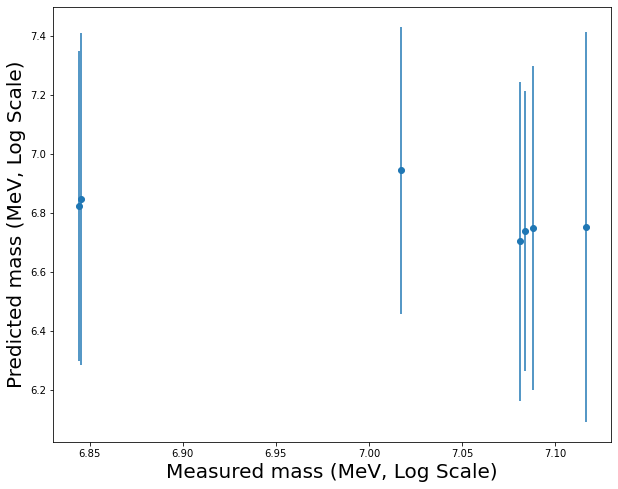

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 4.599999999999999, length_scale: 4.599999999999999
[ 920.86038382  942.17439489 1037.43169183  815.76498112  845.53454593
  853.61662126  856.43925525] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530349 0.56392011 0.48741777 0.54007146 0.47415335 0.54962124
 0.66086798] 



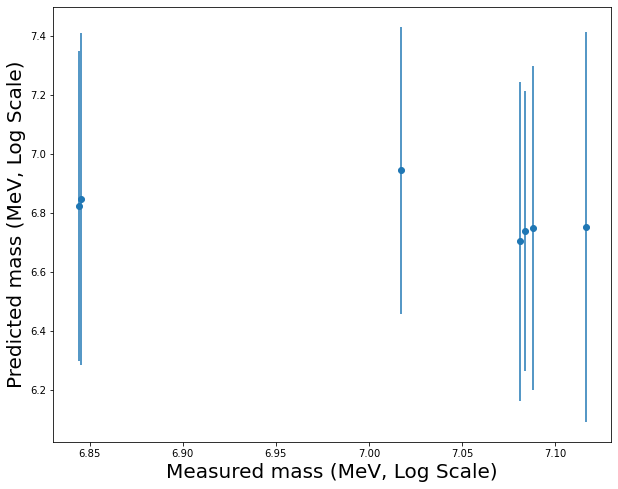

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 4.699999999999998, length_scale: 4.699999999999998
[ 920.86051506  942.17453487 1037.43177825  815.76510691  845.5346269
  853.61676495  856.43947307] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530345 0.56392007 0.48741774 0.54007143 0.47415332 0.5496212
 0.66086794] 



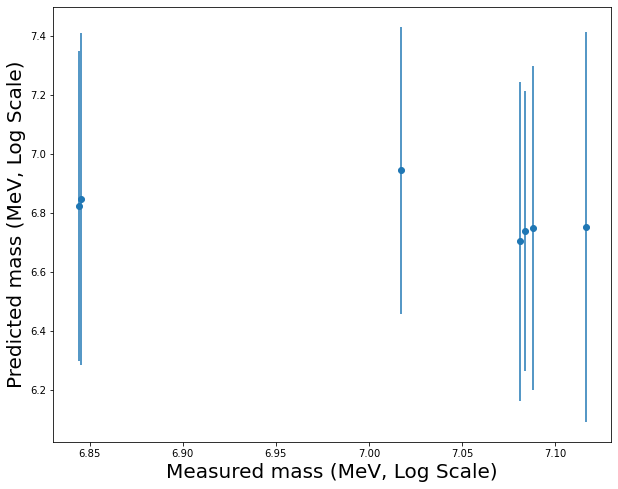

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 4.799999999999999, length_scale: 4.799999999999999
[ 920.86059113  942.17461111 1037.43177819  815.76519772  845.53465244
  853.61685918  856.43969425] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530349 0.56392011 0.48741778 0.54007147 0.47415336 0.54962123
 0.66086797] 



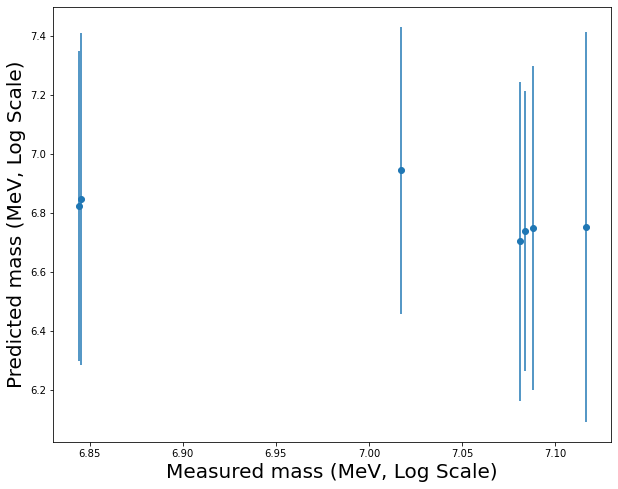

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 4.899999999999999, length_scale: 4.899999999999999
[ 920.86047899  942.1745019  1037.43181101  815.76505216  845.53462874
  853.6167131   856.43930618] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.5253034  0.56392002 0.48741768 0.54007138 0.47415326 0.54962115
 0.66086789] 



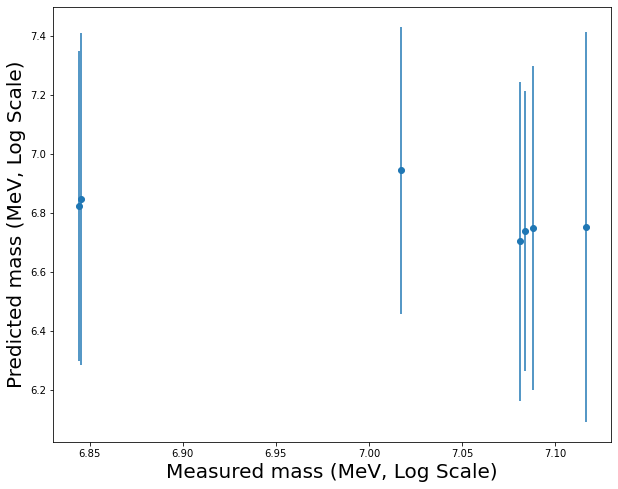

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 4.999999999999998, length_scale: 4.999999999999998
[ 920.86054707  942.17457602 1037.43187129  815.76511188  845.53467733
  853.61678424  856.43938989] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530337 0.56391998 0.48741764 0.54007134 0.47415323 0.54962112
 0.66086785] 



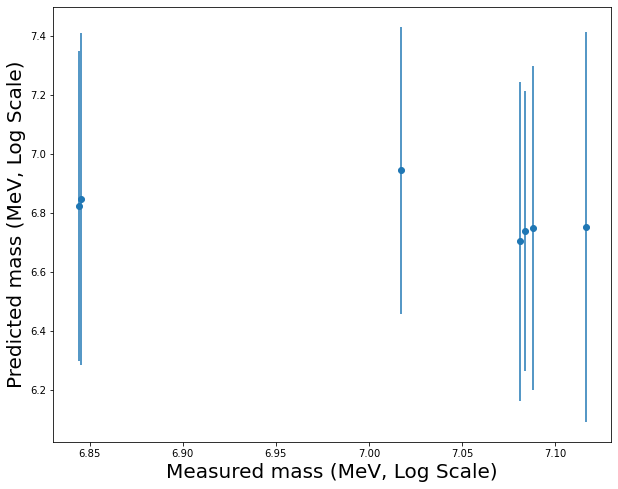

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 5.099999999999999, length_scale: 5.099999999999999
[ 920.86027283  942.17426991 1037.43155086  815.76489901  845.53444852
  853.61651462  856.43919964] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530359 0.56392022 0.48741788 0.54007157 0.47415345 0.54962134
 0.66086809] 



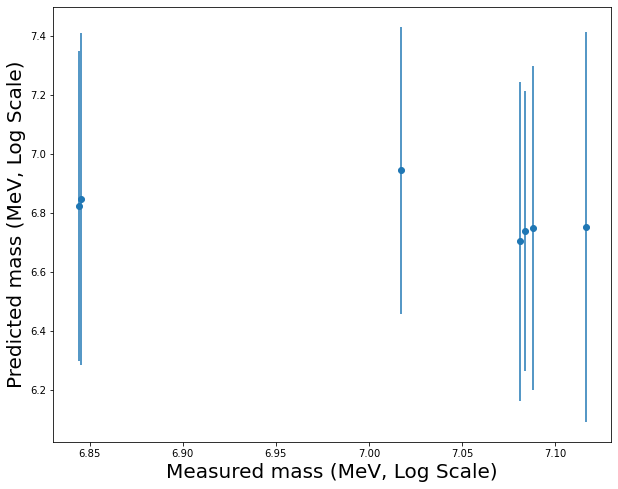

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 5.199999999999998, length_scale: 5.199999999999998
[ 920.86046761  942.17448881 1037.43179374  815.76504474  845.53461755
  853.61670277  856.43930579] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530342 0.56392003 0.48741769 0.54007139 0.47415328 0.54962116
 0.6608679 ] 



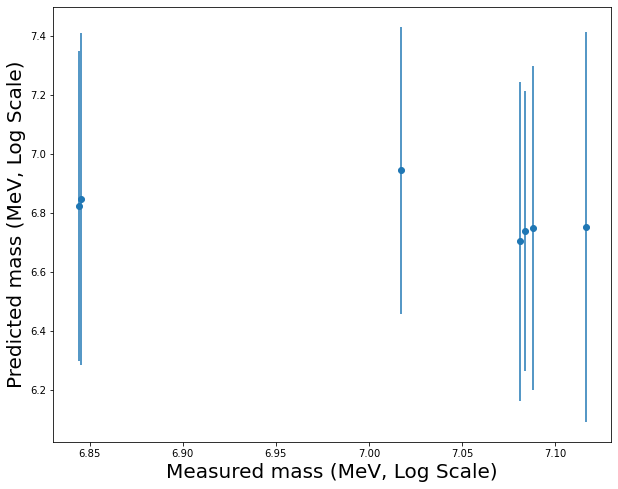

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 5.299999999999999, length_scale: 5.299999999999999
[ 920.86068719  942.17473203 1037.43203096  815.76522209  845.53479251
  853.61692288  856.43949474] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530326 0.56391986 0.48741753 0.54007123 0.47415312 0.54962101
 0.66086773] 



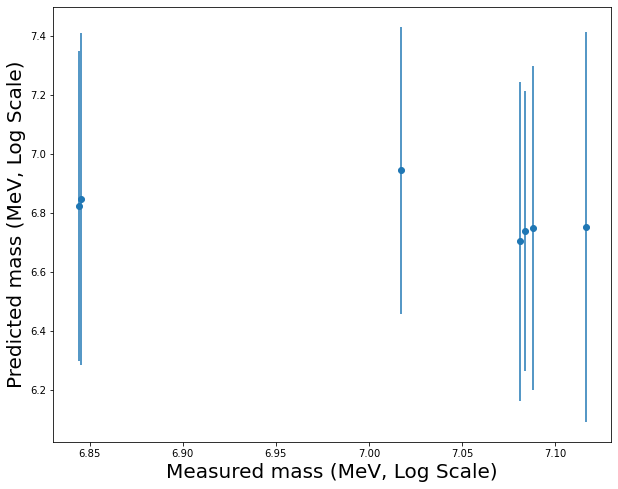

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 5.399999999999999, length_scale: 5.399999999999999
[ 920.86049249  942.17449481 1037.43159945  815.76514383  845.53454307
  853.61677609  856.43974606] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530363 0.56392028 0.48741794 0.54007162 0.47415351 0.54962138
 0.66086813] 



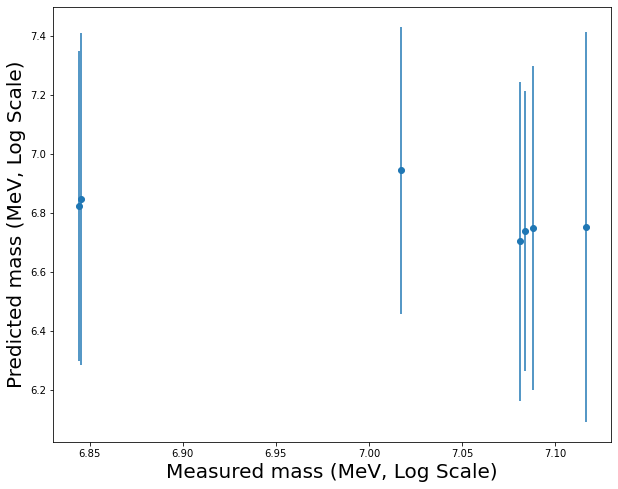

Current hyperparams: 
 noise: 1.9599999999999997, constant_value: 5.499999999999998, length_scale: 5.499999999999998
[ 920.86038381  942.17439488 1037.43169183  815.76498112  845.53454593
  853.61662126  856.43925523] 
 [ 938.27210729  939.56781663 1115.68071016 1189.37114875 1192.64642084
 1197.4505092  1231.99489449] 
 [0.52530349 0.56392011 0.48741777 0.54007146 0.47415335 0.54962124
 0.66086798] 



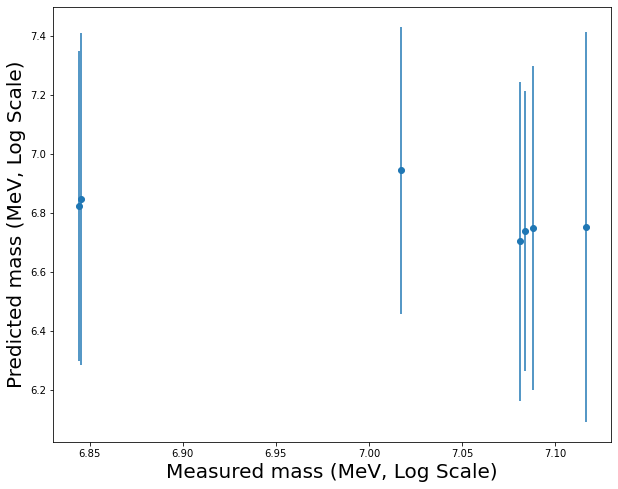

In [36]:
# noise = np.arange(0.05, 4.05, 0.05)
noise = 1.4**2
constant_value = np.arange(0.6, 5.6, 0.1)
length_scale = np.arange(0.6, 5.6, 0.1)
# for rq kernel
alpha = np.arange(0.6, 5.6, 0.1)

hyperparams = list(zip(constant_value, length_scale))

# For writing results to file
results_df = pd.DataFrame()

for counter, params in enumerate(hyperparams):
    # Change params indexing as tuple elements are added/removed from hyperparams
    sigma_f = params[0]
    l = params[1]
    print(f'Current hyperparams: \n noise: {noise}, constant_value: {sigma_f}, length_scale: {l}')

    rbf = ConstantKernel(sigma_f) * RBF(length_scale=l)
    # rq = ConstantKernel(1.0) * RationalQuadratic(length_scale=1.0, alpha=1.0)

    # Set GP prior to training data's mean and cov with kernel
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise, n_restarts_optimizer=10)

    gpr.fit(X_train, Y_train)
    mean, cov = gpr.predict(X_test, return_std=True)
    
    # Store current iteration data
    print(np.exp(mean), '\n', np.exp(Y_test), '\n', cov, '\n')
    current_results_df = pd.DataFrame({'run': counter, 'measured': np.exp(Y_test), 'predicted': np.exp(mean), 'variance': np.exp(cov),
                            'rmse': mean_absolute_error(Y_test, mean), 'alpha/noise': noise,
                            'initial_length scale': l, 'initial_sigma_f': sigma_f,
                            'trained_length_scale': gpr.kernel_.k2.get_params()['length_scale'],
                            'trained_sigma_f': np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])})
    
    # Draw plots
    plotter(Y_test, mean, cov)
    
    # Join dataframes to save 
    results_df = pd.concat([results_df, current_results_df])
    
# write to file
results_df.round(4).to_csv('results.csv', index=False)

In [77]:
results_df.shape

(40, 8)

In [17]:
def plotter(ground_truth, prediction, cov):
    # Plot the mean and variances
    fig, ax = plt.subplots(figsize=(10, 8))

    # Set font size
    FONT_MEDIUM = 20
    plt.rc('axes', labelsize=FONT_MEDIUM)    # fontsize of the x and y labelsb

    ax.scatter(ground_truth, prediction)
    ax.errorbar(ground_truth, prediction, yerr=cov, linestyle='None')
    ax.set_ylabel('Predicted mass (MeV, Log Scale)')
    ax.set_xlabel('Measured mass (MeV, Log Scale)')
    plt.show()

### LOOCV

In [11]:
# Leave-one-out
loo = LeaveOneOut()
n_splits = loo.get_n_splits(X)

l = []
mu = []
cov = []
sigma_f = []
for train_index, test_index in loo.split(X):
#     print('Train index: ', train_index, 'Test index: ', test_index)
    X_star, X_train = X[test_index], X[train_index]
    
    # Replace the Y's with Y_log, Y_normalized, or Y_noisy as needed
    Y_star, Y_train = Y_log[test_index], Y_log[train_index]
    
    # Reuse training data
    gpr.fit(X_train, Y_train)

    # Compute posterior mean and covariance
    # Y_star
    mu_s, cov_s = gpr.predict(X_star, return_std=True)
    mu.append(mu_s)
    cov.append(cov_s)
    
    print('log y_star: ', Y_star)
    print('Predicted y_star: ', mu_s)
    print('Predicted std: ', cov_s)
    print('Test index: ', test_index)
    
    # Obtain optimized kernel parameters
    l.append(gpr.kernel_.k2.get_params()['length_scale'])
    sigma_f.append(np.sqrt(gpr.kernel_.k1.get_params()['constant_value']))
    break

# Plot the results
# plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)


log y_star:  [[4.93856906]]
Predicted y_star:  [[5.76014688]]
Predicted std:  [0.32051062]
Test index:  [0]
